<font size="5">Procesar imagenes ABI y seguir un sistema de nubes en el tiempo. Extraer informaciones globales como Areas de lluvia fuerte y débil</font>

### Tormenta a procesar:
Inicio: 13/03/2023 21 UTC

Fin:    14/03/2023 15 UTC

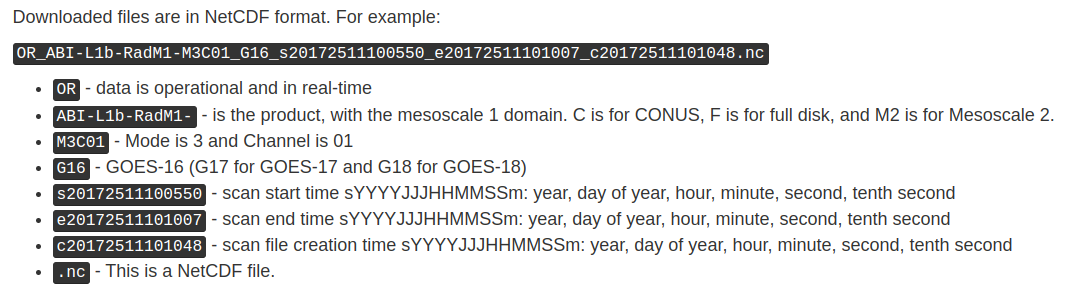

In [35]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import numpy as np
import matplotlib

from netCDF4 import Dataset
import cartopy.crs as ccrs  # Plot maps
import os
import sys

from util_imag_2023 import *


# Función de realce lineal al p porciento
def realce(vec, p=2, gamma=1):
    aux = np.sort(vec.flatten())
    imin = int(len(aux) * p / 100)
    imax = int(len(aux) * (100 - p) / 100)
    vmin = float(aux[imin])
    vmax = float(aux[imax])
    rimag = ( (vec - vmin) / (vmax - vmin) )**gamma
    rimag[rimag < 0] = 0
    rimag[rimag > 1] = 1
    return rimag

def pca(X):
    '''
    Obtiene la descomposición PCA de una imagen de entrada.
    
    Parámetros
    ----------
    X : numpy.array
        Imagen de entrada cuyas dimensiones son [filas, columnas, bandas].
    
    Retornos
    --------
    x_pca : numpy.array
        Array con las componentes principales cuyas dimensiones
        son [filas*columnas, bandas].
    eigen_vals : numpy.array
        Array con los eigen values. 
    eigen_vecs : numpy.array
        Array con los eigen vectors.
    '''
    # Obtenemos las dimensiones
    filas, columnas, bandas = X.shape
    # Reacomodamos la matriz a 2 dimensiones
    xr = np.reshape(X, [filas * columnas, bandas])
    # Centro los datos
    xr = xr - xr.mean(axis=0)
    # Calculamos la matriz de covarianza
    C = np.dot(xr.T, xr) / (filas * columnas - 1)
    # Realizamos la descomposición
    eigen_vals, eigen_vecs = np.linalg.eig(C)
    X_pca = np.dot(xr, eigen_vecs)
    return X_pca, eigen_vals, eigen_vecs



def pca_modificada(X, eigen_vecs):
    '''
    Obtiene la descomposición PCA de una imagen de entrada.
    
    Parámetros
    ----------
    X : numpy.array
        Imagen de entrada cuyas dimensiones son [filas, columnas, bandas].
    eigen_vecs : numpy.array
        Array con los eigen vectors.
    
    Retornos
    --------
    x_pca : numpy.array
        Array con las componentes principales cuyas dimensiones
        son [filas*columnas, bandas].

    '''
    # Obtenemos las dimensiones
    filas, columnas, bandas = X.shape
    # Reacomodamos la matriz a 2 dimensiones
    xr = np.reshape(X, [filas * columnas, bandas])
    # Centro los datos
    xr = xr - xr.mean(axis=0)
    # Calculamos la matriz de covarianza
    #C = np.dot(xr.T, xr) / (filas * columnas - 1)
    # Realizamos la descomposición
    # eigen_vals, eigen_vecs = np.linalg.eig(C)
    X_pca = np.dot(xr, eigen_vecs)
    return X_pca



import matplotlib.colors as mcolors

cmap_data_p = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             #(0.501960813999176, 0.501960813999176, 0.501960813999176),
             #(0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             #(0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             #(0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             #(0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             #(0.4000000059604645, 0.20000000298023224, 0.0)
              ]
cmap_p = mcolors.ListedColormap(cmap_data_p, 'precipitation_p')


import matplotlib.colors as mcolors

cmap_data = [(1.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (1.0, 0.0, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')


bounds = [0,0.1,20,100]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

In [52]:
dir_nc = '/home/msuarez/GOES_16_TF/14032023/'

CH08_list = glob.glob(dir_nc+'CH08/*.nc')
CH08_list.sort()

CH10_list = glob.glob(dir_nc+'CH10/*.nc')
CH10_list.sort()

CH12_list = glob.glob(dir_nc+'CH12/*.nc')
CH12_list.sort()

QPE_list  = glob.glob(dir_nc+'QPE/*.nc')
QPE_list.sort()

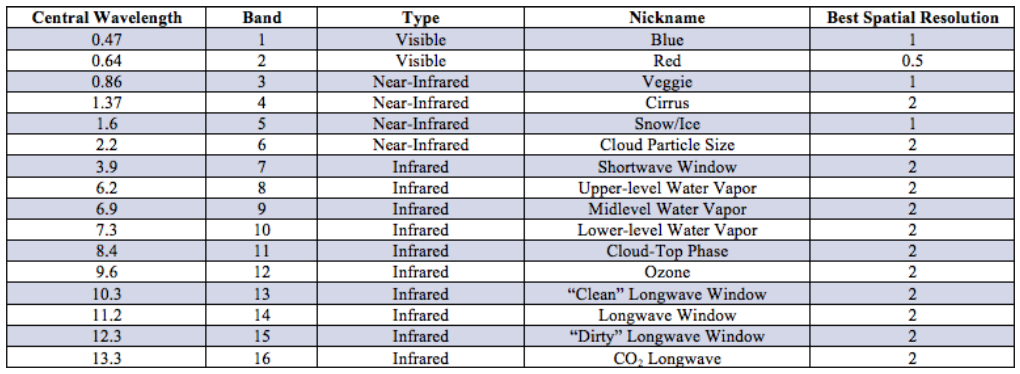

# Graficamos todos los plots de la misma banda cargados anteriormente

In [60]:
# fig, ax = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(13, 13))
# ax = ax.ravel()

# for i in range(len(imag_cal_list)):
#     im = ax[i].imshow(imag_cal_list[i], cmap='jet')
#     ax[i].set_title('Banda '+str(metadato_list[i]['band_id'][:]))
#     ax[i].set_xticklabels('')
#     ax[i].set_yticklabels('')
#     fig.colorbar(im, shrink=.5, ax=ax[i])
    
# plt.tight_layout()
# plt.show()

# Esto es para ver el recorte

In [49]:
# path = '/home/msuarez/GOES_16_TF/14032023/'
# img = Dataset(path+'CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730000205_e20230730009517_c20230730009565.nc', 'r')

# metadato = img.variables

# # sup_row = 4200
# # inf_row = 4600
# # sup_col = 2900
# # inf_col = 3300

# # CENTRO DE LA ARGENTINA
# sup_row = 4200
# inf_row = 4600
# sup_col = 2900
# inf_col = 3400

# # True para recortar
# recortar = False

# # altura de la orbita del satelite en metros (35786023.0)
# altura=metadato['goes_imager_projection'].perspective_point_height
# # 6378137.0 semieje mayor en metros
# semieje_may=metadato['goes_imager_projection'].semi_major_axis
# # 6356752.31414 semieje menor en metros
# semieje_men=metadato['goes_imager_projection'].semi_minor_axis
# # -75 longitud central
# lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin

# #img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
# img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
# pol=semieje_may*altura/(semieje_may+altura) # 5413321.583523803
# ecu=semieje_men*altura/(semieje_may+altura) # 5395171.741097588

# icanal = int(metadato['band_id'][:])
# print ('Procesando Canal %d' %icanal)
# #print('pol',pol,' ecu',ecu)
# ####################################################################################################
# imagen = metadato['Rad'][:].data
# print('Tamaño original de la imagen:',imagen.shape)

# if recortar:
#     print('Recortando imagen')
#     # Bandas de 1 km de resolución espacial
#     if (icanal == 1) or (icanal == 3) or (icanal == 5):
#         print('entra al if 1,3,5')
#         imagen = imagen[sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2]
#     # Bandas de 0.5 km de resolución espacial
#     elif icanal == 2:
#         print('entra al elif 2')
#         imagen = imagen[sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4]
#     # Bandas de 2 km de resolución espacial
#     else:
#         print('entra al else')
#         imagen = imagen[sup_row:inf_row,sup_col:inf_col]
# else:
#     print('No se recorta imagen')
    
    
    
# if icanal >7:
#     print ('Calibrando la imagen (if)')
#     #Parámetros de calibracion
#     fk1 = metadato['planck_fk1'][0] # DN -> K  (=13432.1)
#     fk2 = metadato['planck_fk2'][0] # (=1497.61)
#     bc1 = metadato['planck_bc1'][0] # (=0.09102)
#     bc2 = metadato['planck_bc2'][0] # (=0.99971)

#     imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2-273.15 # K -> C
#     # imag_cal es un array de (5424, 5424)
#     Unit = "Temperatura de Brillo [°C]"
# else:
#     print ('Calibrando la imagen (else)')
#     pendiente= metadato['Rad'].scale_factor
#     ordenada= metadato['Rad'].add_offset
#     imag_cal =imagen*pendiente+ordenada
#     Unit = "Radiancia ["+metadato['Rad'].units+"]"  
    
    
# img = plt.imshow(imag_cal,vmin=-100,vmax=30, cmap='jet')
# plt.plot([sup_col,inf_col],[sup_row,sup_row], color='black')
# plt.plot([sup_col,inf_col],[inf_row,inf_row], color='black')
# plt.plot([inf_col,inf_col],[inf_row,sup_row], color='black')
# plt.plot([sup_col,sup_col],[inf_row,sup_row], color='black')
# plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both',
#              orientation='vertical',pad=0.05, fraction=0.05)


# plt.show()

In [50]:
# plt.figure()
# #proyeccion geoestacionaria para Goes16
# crs=ccrs.Geostationary(central_longitude=lon_cen, satellite_height=altura)
# ax = plt.axes(projection=crs)
# ax.gridlines() #agrega linea de meridianos y paralelos
# ax.coastlines(resolution='10m',color='black') #agrega líneas de costa

# img=plt.imshow(imag_cal,extent=img_extent,vmin=-100.,vmax=30.,cmap='jet')
# # Add a colorbar
# plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='vertical',pad=0.05, fraction=0.05)

# plt.show()

In [51]:
# #%% Recortes crudos
# psize=2000 # lado de pixel de referencia en m
# N=5424 #numero de pixeles de referencia

# Nx=2000 #numero de puntos del recorte en x
# Ny=2000 #numero de puntos del recorte en x

# esc=int(imag_cal.shape[0]/N)

# x0=-1200000 # Coordenada x del limite superior izquierdo en m
# y0=-1000000 # Coordenada y del limite superior izquierdo en m

# f0=int((img_extent[1]-y0)/psize*esc) #fila del angulo superior izquierdo
# c0=int((img_extent[3]+x0)/psize*esc) #columna del angulo superior izquierdo
# f1=int(f0+Nx*esc) #fila del angulo inferior derecho
# c1=int(c0+Ny*esc) #columna del angulo inferior derecho

# img_extentr=[x0,x0+Nx*psize*esc,y0-Ny*psize*esc,y0]

# indf=range(f0,f1,esc)
# indc=range(c0,c1,esc)
# # im_rec=imag_cal[:].data[indf,indc]
# im_rec=imag_cal[indf[0]:indf[-1],indc[0]:indc[-1]]

# # plt.figure()
# # img=plt.imshow(im_rec,vmin=-100.,vmax=30.,cmap='jet')
# # plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='vertical',
# #              pad=0.05, fraction=0.05)


# #%%

# # im_rec=imagedata[f0:f1:esc,c0:c1:esc]
# plt.figure()
# ax = plt.axes(projection=crs)
# ax.gridlines() #agrega linea de meridianos y paralelos
# ax.coastlines(resolution='10m',color='black') #agrega líneas de costa

# img=plt.imshow(im_rec,transform=crs, extent=img_extentr,vmin=-100.,vmax=30.,cmap='jet')
# plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='vertical',
#              pad=0.05, fraction=0.05)

# plt.show()

# Aca se cargan todas las bandas del mismo t

## La función de este bloque es trabajar con las distintas bandas y explorar cuales son mejores para funcionar como mascara lluvia fuerte-debil

In [28]:
path = '/home/msuarez/GOES_16_TF/14032023/'


list_imgs = ['CH08/OR_ABI-L1b-RadF-M6C08_G16_s20230730000205_e20230730009513_c20230730009575.nc',
             'CH09/OR_ABI-L1b-RadF-M6C09_G16_s20230730000205_e20230730009519_c20230730009581.nc',
             'CH10/OR_ABI-L1b-RadF-M6C10_G16_s20230730000205_e20230730009525_c20230730009554.nc',
             'CH11/OR_ABI-L1b-RadF-M6C11_G16_s20230730000205_e20230730009514_c20230730009568.nc',
             'CH12/OR_ABI-L1b-RadF-M6C12_G16_s20230730000205_e20230730009519_c20230730009573.nc',
             'CH13/OR_ABI-L1b-RadF-M6C13_G16_s20230730000205_e20230730009525_c20230730009576.nc',
             'CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730000205_e20230730009517_c20230730009565.nc',
             'CH15/OR_ABI-L1b-RadF-M6C15_G16_s20230730000205_e20230730009523_c20230730009571.nc',
             'CH16/OR_ABI-L1b-RadF-M6C16_G16_s20230730000205_e20230730009529_c20230730009560.nc']

#list_imgs = ['CH08/OR_ABI-L1b-RadF-M6C08_G16_s20230730200205_e20230730209513_c20230730209575.nc',
#            'CH09/OR_ABI-L1b-RadF-M6C09_G16_s20230730200205_e20230730209519_c20230730209566.nc',
#            'CH10/OR_ABI-L1b-RadF-M6C10_G16_s20230730200205_e20230730209525_c20230730209573.nc',
#            'CH11/OR_ABI-L1b-RadF-M6C11_G16_s20230730200205_e20230730209513_c20230730209559.nc',
#            'CH12/OR_ABI-L1b-RadF-M6C12_G16_s20230730200205_e20230730209519_c20230730209581.nc',
#            'CH13/OR_ABI-L1b-RadF-M6C13_G16_s20230730200205_e20230730209527_c20230730209583.nc',
#            'CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730200205_e20230730209514_c20230730209575.nc',
#            'CH15/OR_ABI-L1b-RadF-M6C15_G16_s20230730200205_e20230730209520_c20230730209578.nc',
#            'CH16/OR_ABI-L1b-RadF-M6C16_G16_s20230730200205_e20230730209528_c20230730209555.nc']

QPE_img = 'QPE/OR_ABI-L2-RRQPEF-M6_G16_s20230730000205_e20230730009513_c20230730010027.nc'
#QPE_img = 'QPE/OR_ABI-L2-RRQPEF-M6_G16_s20230730200205_e20230730209513_c20230730210044.nc'

qpe_obj = Dataset(path+QPE_img, 'r')

imagenobj_list = []

print('Importando imagenes...')
for i in range(len(list_imgs)): imagenobj_list.append(Dataset(path+list_imgs[i], 'r'))
print('Imagenes importadas en la lista imagenobj_list.')

metadato_list = [imagenobj_list[i].variables for i in range(len(list_imgs))]

# Recorte en la Argentina basados en las bandas con 2 km de resolución espacial
# Si la banda es de 1 km y 0.5 km de resolución entonces se debe multiplicar estos valores por 2 y 4
# respectivamente, de forma tal de obtener el mismo recorte

# RECORTE DE SUDAMERICA
#sup_row = 4000
#inf_row = 5000
#sup_col = 2500
#inf_col = 3600

# CENTRO DE LA ARGENTINA
sup_row = 4200
inf_row = 4600
sup_col = 2900
inf_col = 3400

print('Tamaño del recorte: Alto=',inf_row-sup_row,' Ancho=',inf_col-sup_col)

imagen_list = []
imag_cal_list = []

for metadato in metadato_list:
    
    try:
        # altura de la orbita del satelite en metros (35786023.0)
        altura=metadato['goes_imager_projection'].perspective_point_height
        # 6378137.0 semieje mayor en metros
        semieje_may=metadato['goes_imager_projection'].semi_major_axis
        # 6356752.31414 semieje menor en metros
        semieje_men=metadato['goes_imager_projection'].semi_minor_axis
        # -75 longitud central
        lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin

        #img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
        img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
        pol=semieje_may*altura/(semieje_may+altura) # 5413321.583523803
        ecu=semieje_men*altura/(semieje_may+altura) # 5395171.741097588

        icanal = int(metadato['band_id'][:])
        print ('Procesando Canal %d' %icanal)
        #print('pol',pol,' ecu',ecu)
        ####################################################################################################
        imagen = metadato['Rad'][:].data
        print('Tamaño original de la imagen:',imagen.shape)
        print('Recortando imagen')
        # Bandas de 1 km de resolución espacial
        if (icanal == 1) or (icanal == 3) or (icanal == 5):
            print('entra al if 1,3,5')
            imagen = imagen[sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2]
        # Bandas de 0.5 km de resolución espacial
        elif icanal == 2:
            print('entra al elif 2')
            imagen = imagen[sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4]
        # Bandas de 2 km de resolución espacial
        else:
            print('entra al else')
            imagen = imagen[sup_row:inf_row,sup_col:inf_col]
        ####################################################################################################
        if icanal >7:
            print ('Calibrando la imagen (if)')
            #Parámetros de calibracion
            fk1 = metadato['planck_fk1'][0] # DN -> K  (=13432.1)
            fk2 = metadato['planck_fk2'][0] # (=1497.61)
            bc1 = metadato['planck_bc1'][0] # (=0.09102)
            bc2 = metadato['planck_bc2'][0] # (=0.99971)

            imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2-273.15 # K -> C
            imag_cal_list.append(imag_cal)
            # imag_cal es un array de (5424, 5424)
            Unit = "Temperatura de Brillo [°C]"
        else:
            print ('Calibrando la imagen (else)')
            pendiente= metadato['Rad'].scale_factor
            ordenada= metadato['Rad'].add_offset
            imag_cal =imagen*pendiente+ordenada
            imag_cal_list.append(imag_cal)
            Unit = "Radiancia ["+metadato['Rad'].units+"]"  
    except:
        print('Se ingresó al bloque except!')
        continue
        
    print('\n') 

Importando imagenes...
Imagenes importadas en la lista imagenobj_list.
Tamaño del recorte: Alto= 400  Ancho= 500
Procesando Canal 8
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 9
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 10
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 11
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 12
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 13
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 15
Tamaño o

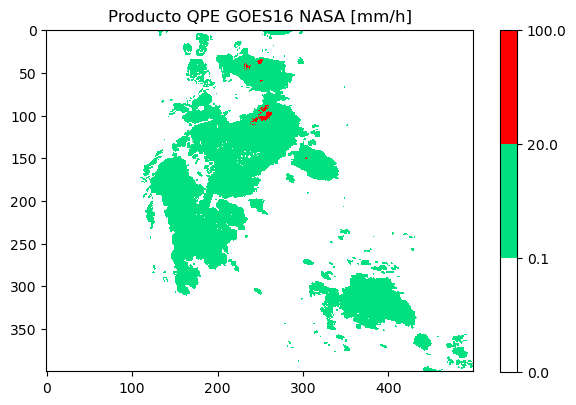

In [145]:
plt.figure(figsize=(6, 6))

plt.subplot(111)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
           cmap=cmap, norm=norm)

plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)

plt.title('Producto QPE GOES16 NASA [mm/h]')
plt.tight_layout()
plt.show()

# Hago un dispersograma de todas las bandas

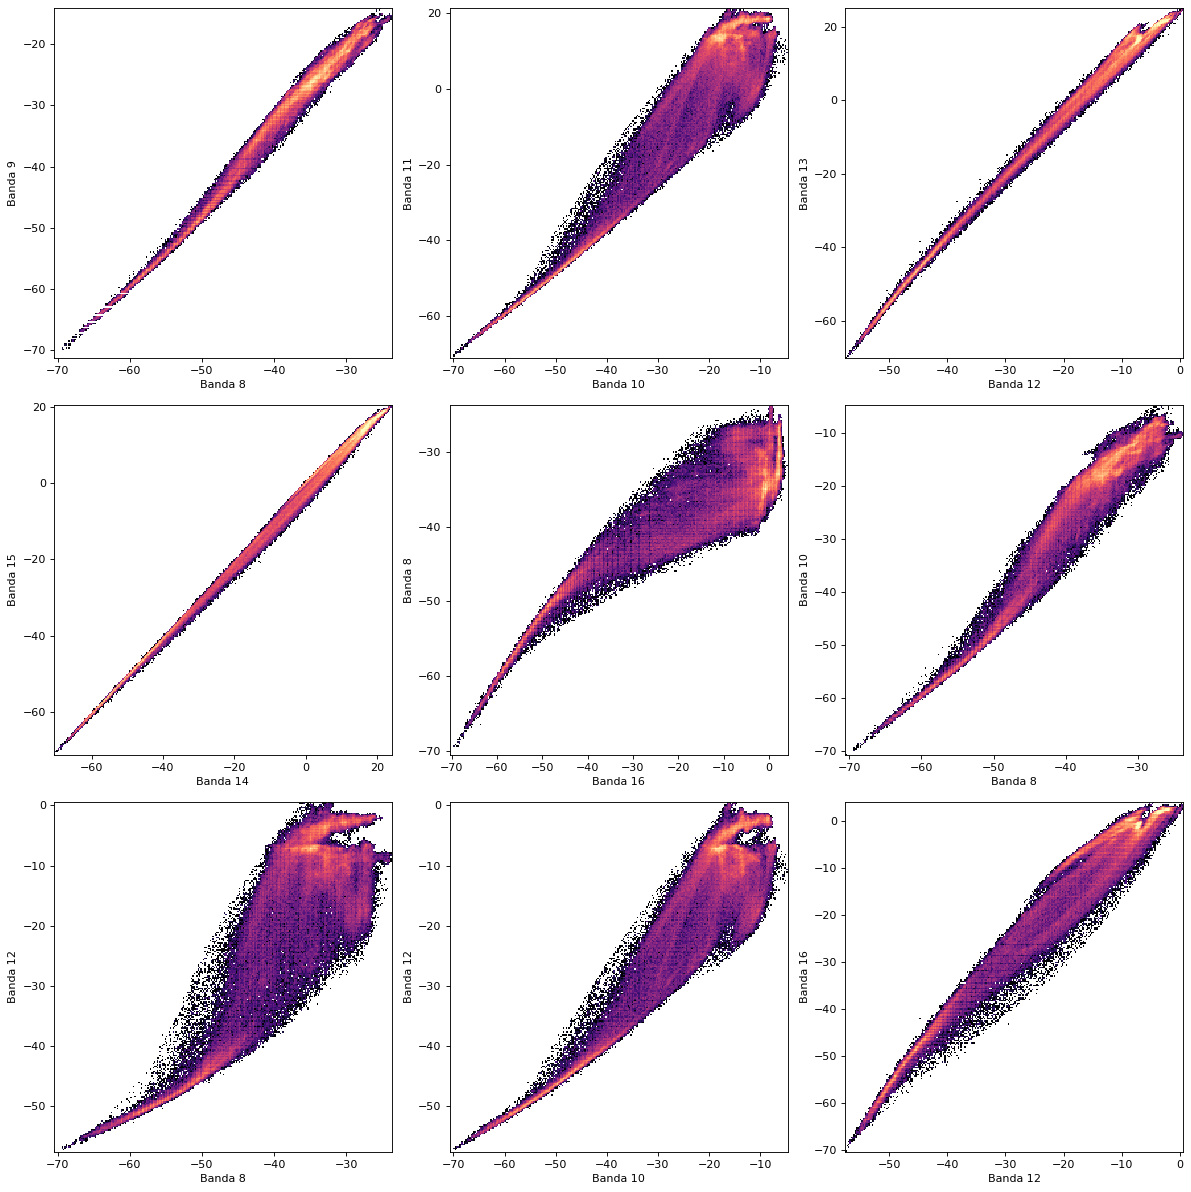

In [66]:
import matplotlib

# Creamos un objeto para normalizar las gráficas de forma logarítmica
lognorm = matplotlib.colors.LogNorm()

# Creamos la figura
plt.figure(figsize=(15, 15), dpi=80)

# Graficamos el dispersograma de las bandas 1 y 2
plt.subplot(3, 3, 1)

plt.hist2d(imag_cal_list[0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[1].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 8 y 9')
plt.xlabel('Banda 8')
plt.ylabel('Banda 9')

# Graficamos el dispersograma de las bandas 4 y 5
plt.subplot(3, 3, 2)

plt.hist2d(imag_cal_list[2].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[3].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 10 y 11')
plt.xlabel('Banda 10')
plt.ylabel('Banda 11')

# Graficamos el dispersograma de las bandas 6 y 3
plt.subplot(3, 3, 3)

plt.hist2d(imag_cal_list[4].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[5].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 12')
plt.ylabel('Banda 13')

plt.subplot(3, 3, 4)

plt.hist2d(imag_cal_list[6].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[7].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 14')
plt.ylabel('Banda 15')


plt.subplot(3, 3, 5)

plt.hist2d(imag_cal_list[8].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[0].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 16')
plt.ylabel('Banda 8')


plt.subplot(3, 3, 6)

plt.hist2d(imag_cal_list[0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[2].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 8')
plt.ylabel('Banda 10')


plt.subplot(3, 3, 7)

plt.hist2d(imag_cal_list[0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[4].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 8')
plt.ylabel('Banda 12')


plt.subplot(3, 3, 8)

plt.hist2d(imag_cal_list[2].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[4].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 10')
plt.ylabel('Banda 12')


plt.subplot(3, 3, 9)

plt.hist2d(imag_cal_list[4].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[8].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 12')
plt.ylabel('Banda 16')


plt.tight_layout()
plt.show()

# Definicion de la funcion para analisis de componentes principales

In [67]:
len(imag_cal_list)

9

# Se grafican combinaciones RGB de las distintas bandas con opción de pasar a negativo (1-banda)

In [68]:
# combinaciones = [[0,1,2],[3,4,5],[6,7,8],[0,7,8],
#                  [0,2,4],[1,3,8],[2,4,6],[3,4,6],
#                  [0,3,6],[0,4,8],[1,3,7],[2,5,8]]

# n=1

# negativo_R = False
# negativo_G = False
# negativo_B = False

# tercera_dim = 3

# for i,j,k in combinaciones:
    
#     RGBrec = np.zeros((inf_row-sup_row, inf_col-sup_col, tercera_dim))
    
#     print('Bandas:',i+8,j+8,k+8)
#     RGBrec[:, :, 0] = imag_cal_list[i]
#     RGBrec[:, :, 1] = imag_cal_list[j]
#     RGBrec[:, :, 2] = imag_cal_list[k]
    
#     title_markR = 'RN'
#     title_markG = 'GN'
#     title_markB = 'BN'
    
#     if negativo_R:
#         RGBrec[:, :, 0] = 1-imag_cal_list[i]
#     if negativo_G:
#         RGBrec[:, :, 1] = 1-imag_cal_list[j]
#     if negativo_B:
#         RGBrec[:, :, 2] = 1-imag_cal_list[k]

#     # Aplicamos PCA a la imagen RGB recortada original (sin realzar!!!!)
#     x_pca, eigen_vals, eigen_vecs = pca(RGBrec)

#     # Hacemos un realce a las componentes principales para graficarlas (sólo para visualización!!!)
#     # NOTA: Observe que la función realc() debe recibir un array 3D, y que x_pca es un array de dos 
#     #       dimensiones (verifíquelo). Por esto tenemos que hacer antes un reshape a x_pca para llevarlo a las
#     #       dimensiones adecuadas para aplicar la función.
#     # x_pca_3d = np.reshape(x_pca, [..., ..., ...])
#     x_pca_3d = np.reshape(x_pca, [inf_row-sup_row, inf_col-sup_col, tercera_dim])

#     # Aplique un realce a x_pca_3d
#     x_pca_3d_realzada = np.zeros_like(x_pca_3d)
#     for l in range(tercera_dim):
#         x_pca_3d_realzada[:, :, l] = realce(x_pca_3d[:, :, l], p=0.2)

#     # Aplique un realce a x_pca_3d
#     RGBrec_realzada = np.zeros((inf_row-sup_row, inf_col-sup_col, tercera_dim))
#     for m in range(tercera_dim):
#         RGBrec_realzada[:,:,m] = realce(RGBrec[:,:,m], p=0.2)

#     plt.figure(figsize=(15, 6))

#     plt.subplot(131)
#     plt.imshow(RGBrec_realzada)
#     plt.title("Imagen Original RGB realzada")

#     plt.subplot(132)
#     plt.imshow(x_pca_3d_realzada, cmap='jet')
    
#     title_fig = str(n)
#     plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+'\nComponentes principales realzada')
    
#     if negativo_R:
#         plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+title_markR+'\nComponentes principales realzada')
#         title_fig = title_markR+'_'+str(n)
#     if negativo_G:
#         plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+title_markG+'\nComponentes principales realzada')
#         title_fig = title_markG+'_'+str(n)
#     if negativo_B:
#         plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+title_markB+'\nComponentes principales realzada')
#         title_fig = title_markB+'_'+str(n)
#     if negativo_R and negativo_G:
#         plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+title_markR+title_markG+'\nComponentes principales realzada')
#         title_fig = title_markR+title_markG+'_'+str(n)
#     if negativo_R and negativo_B:
#         plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+title_markR+title_markB+'\nComponentes principales realzada')
#         title_fig = title_markR+title_markB+'_'+str(n)
#     if negativo_B and negativo_G:
#         plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+title_markB+title_markG+'\nComponentes principales realzada')
#         title_fig = title_markB+title_markG+'_'+str(n)
#     if negativo_R and negativo_B and negativo_G:
#         plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+title_markR+title_markB+title_markG+'\nComponentes principales realzada')
#         title_fig = title_markR+title_markB+title_markG+'_'+str(n)
    
#     plt.subplot(133)
#     plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
#                cmap=cmap, vmin=0, vmax=100)
#     plt.title("Producto QPE")
#     # plt.colorbar(shrink=.2)
    
#     plt.tight_layout()
#     #plt.savefig('/home/msuarez/GOES_16_TF/Figuras/Figura_'+title_fig+'.png', dpi=200)
    
#     n=n+1
    
#     plt.show()

In [69]:
# i = 8-8
# j = 10-8
# k = 11-8
# p = 13-8
# q = 14-8
# o = 16-8

# dims = 6

# RGBrec = np.zeros((inf_row-sup_row, inf_col-sup_col, dims))

# RGBrec[:, :, 0] = imag_cal_list[i]
# RGBrec[:, :, 1] = imag_cal_list[j]
# RGBrec[:, :, 2] = imag_cal_list[k]
# RGBrec[:, :, 3] = imag_cal_list[p]
# RGBrec[:, :, 4] = imag_cal_list[q]
# RGBrec[:, :, 5] = imag_cal_list[o]

# # Aplicamos PCA a la imagen RGB recortada original (sin realzar!!!!)
# x_pca, eigen_vals, eigen_vecs = pca(RGBrec)

# # Hacemos un realce a las componentes principales para graficarlas (sólo para visualización!!!)
# # NOTA: Observe que la función realc() debe recibir un array 3D, y que x_pca es un array de dos 
# #       dimensiones (verifíquelo). Por esto tenemos que hacer antes un reshape a x_pca para llevarlo a las
# #       dimensiones adecuadas para aplicar la función.
# # x_pca_3d = np.reshape(x_pca, [..., ..., ...])
# x_pca_3d = np.reshape(x_pca, [inf_row-sup_row, inf_col-sup_col, dims])

# # Aplique un realce a x_pca_3d
# x_pca_3d_realzada = np.zeros_like(x_pca_3d)
# for l in range(dims):
#     x_pca_3d_realzada[:, :, l] = realce(x_pca_3d[:, :, l])

# # Aplique un realce a x_pca_3d
# RGBrec_realzada = np.zeros((inf_row-sup_row, inf_col-sup_col, dims))
# for m in range(dims):
#     RGBrec_realzada[:,:,m] = realce(RGBrec[:,:,m])

# plt.figure(figsize=(15, 6))

# print('x_pca_3d_realzada.shape',x_pca_3d_realzada.shape)

# plt.subplot(121)
# plt.imshow(x_pca_3d_realzada[:,:,0], cmap='coolwarm')
# plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+'\nComponentes principales realzada')

# plt.subplot(122)
# plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
#            cmap=cmap, vmin=0, vmax=100)
# plt.title("Producto QPE")
# # plt.colorbar(shrink=.2)

# plt.tight_layout()
# #plt.savefig('/home/msuarez/GOES_16_TF/Figuras/Figura_'+title_fig+'.png', dpi=200)

# plt.show()

# Nos quedamos con una potencial combinacion RGB para detectar areas de lluvias debiles y fuertes

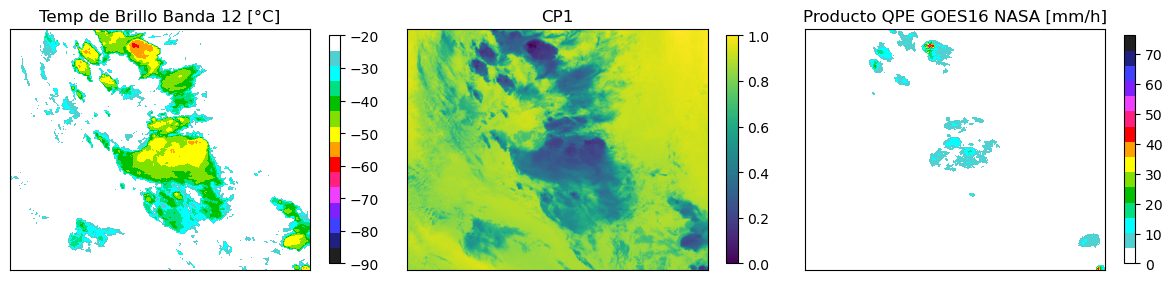

In [30]:
RGBrec = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))

bandaR = 8-8
bandaG = 10-8
bandaB = 12-8

RGBrec[:, :, 0] = 1-imag_cal_list[bandaR]
RGBrec[:, :, 1] = imag_cal_list[bandaG]
RGBrec[:, :, 2] = 1-imag_cal_list[bandaB]

# bandaR = 11-8
# bandaG = 12-8
# bandaB = 14-8

# RGBrec[:, :, 0] = 1-imag_cal_list[bandaR]
# RGBrec[:, :, 1] = imag_cal_list[bandaG]
# RGBrec[:, :, 2] = 1-imag_cal_list[bandaB]

# Aplicamos PCA a la imagen RGB recortada original (sin realzar!!!!)
x_pca, eigen_vals, eigen_vecs = pca(RGBrec)

# Hacemos un realce a las componentes principales para graficarlas (sólo para visualización!!!)
# NOTA: Observe que la función realc() debe recibir un array 3D, y que x_pca es un array de dos 
#       dimensiones (verifíquelo). Por esto tenemos que hacer antes un reshape a x_pca para llevarlo a las
#       dimensiones adecuadas para aplicar la función.
# x_pca_3d = np.reshape(x_pca, [..., ..., ...])
x_pca_3d = np.reshape(x_pca, [inf_row-sup_row, inf_col-sup_col, 3])

# Aplique un realce a x_pca_3d
x_pca_3d_realzada = np.zeros_like(x_pca_3d)
for l in range(3):
    x_pca_3d_realzada[:, :, l] = realce(x_pca_3d[:, :, l], p=0.01)

# Aplique un realce a x_pca_3d
RGBrec_realzada = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))
for m in range(3):
    RGBrec_realzada[:,:,m] = realce(RGBrec[:,:,m], p=0.01)

plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.imshow(imag_cal_list[bandaB], cmap=cmap_p.reversed(), vmin=-90.,vmax=-20.)
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.4)
plt.title("Temp de Brillo Banda 12 [°C]")

plt.subplot(132)
plt.imshow(x_pca_3d_realzada[:,:,0])
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.4)
plt.title('CP1')


plt.subplot(133)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
           cmap=cmap_p)#, norm=norm)
plt.title("Producto QPE GOES16 NASA [mm/h]")
plt.colorbar(shrink=.4)#, norm=norm, boundaries=bounds, ticks=bounds)
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 

plt.tight_layout()
plt.show()

# Siguiente bloque para generar imagenes secuenciales de la tormenta

In [ ]:
import cartopy.feature as cf

# border = cf.NaturalEarthFeature(
#     'cultural', 'admin_0_boundary_lines_land', scale='110m') 
# land = cf.NaturalEarthFeature(
#     'physical', 'land', scale='110m', 
#     edgecolor='black', facecolor=cf.COLORS['land'])
ocean = cf.NaturalEarthFeature(
    'physical', 'ocean', scale='50m', 
    edgecolor='none', facecolor=cf.COLORS['water'])



for l in range(len(CH12_list)):
    
    img = Dataset(CH12_list[l], 'r')

    metadato = img.variables

    # altura de la orbita del satelite en metros (35786023.0)
    altura=metadato['goes_imager_projection'].perspective_point_height
    # 6378137.0 semieje mayor en metros
    semieje_may=metadato['goes_imager_projection'].semi_major_axis
    # 6356752.31414 semieje menor en metros
    semieje_men=metadato['goes_imager_projection'].semi_minor_axis
    # -75 longitud central
    lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin

    #img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
    img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
    pol=semieje_may*altura/(semieje_may+altura) # 5413321.583523803
    ecu=semieje_men*altura/(semieje_may+altura) # 5395171.741097588

    icanal = int(metadato['band_id'][:])
    print ('Procesando Canal %d' %icanal)
    #print('pol',pol,' ecu',ecu)
    ####################################################################################################
    imagen = metadato['Rad'][:].data   


    if icanal >7:
        print ('Calibrando la imagen (if)')
        #Parámetros de calibracion
        fk1 = metadato['planck_fk1'][0] # DN -> K  (=13432.1)
        fk2 = metadato['planck_fk2'][0] # (=1497.61)
        bc1 = metadato['planck_bc1'][0] # (=0.09102)
        bc2 = metadato['planck_bc2'][0] # (=0.99971)

        imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2-273.15 # K -> C
        # imag_cal es un array de (5424, 5424)
        Unit = "Temperatura de Brillo [°C]"
    else:
        print ('Calibrando la imagen (else)')
        pendiente= metadato['Rad'].scale_factor
        ordenada= metadato['Rad'].add_offset
        imag_cal =imagen*pendiente+ordenada
        Unit = "Radiancia ["+metadato['Rad'].units+"]"  

    #%% Recortes crudos
    psize=2000 # lado de pixel de referencia en m
    N=5424 #numero de pixeles de referencia

    Nx=800 #numero de puntos del recorte en x
    Ny=800 #numero de puntos del recorte en x

    esc=int(1)#int(imag_cal.shape[0]/N)

    x0=10000 # Coordenada x del limite superior izquierdo en m
    y0=-2350000 # Coordenada y del limite superior izquierdo en m

    f0=int((img_extent[1]-y0)/psize*esc) #fila del angulo superior izquierdo
    c0=int((img_extent[3]+x0)/psize*esc) #columna del angulo superior izquierdo
    f1=int(f0+Nx*esc) #fila del angulo inferior derecho
    c1=int(c0+Ny*esc) #columna del angulo inferior derecho

    img_extentr=[x0,x0+Nx*psize*esc,y0-Ny*psize*esc,y0]

    indf=range(f0,f1,esc)
    indc=range(c0,c1,esc)
    # im_rec=imag_cal[:].data[indf,indc]
    im_rec=imag_cal[indf[0]:indf[-1],indc[0]:indc[-1]]

    crs=ccrs.Geostationary(central_longitude=lon_cen, satellite_height=altura)
    # im_rec=imagedata[f0:f1:esc,c0:c1:esc]
    plt.figure()
    ax = plt.axes(projection=crs)
    ax.gridlines() #agrega linea de meridianos y paralelos
    ax.coastlines(resolution='10m',color='black') #agrega líneas de costa
#     ax.add_feature(border) 
#     ax.add_feature(land) 
    ax.add_feature(ocean) 

    img=plt.imshow(im_rec,transform=crs, extent=img_extentr,vmin=-80.,vmax=-20.,cmap=cmap_p.reversed())
    
    ax.scatter(-64.19052607998151, -31.41072560605113-0.5 , transform=ccrs.PlateCarree(),
               s=100, marker='*', color='black')
    ax.text(-64.19052607998151, -31.41072560605113, 'Córdoba', transform=ccrs.PlateCarree(),
           fontdict={'ha':'center', 'va':'bottom'})
    
    ax.scatter(-58.3909531194226 , -34.614069539608685-0.5, transform=ccrs.PlateCarree(),
               s=100, marker='*', color='black') 
    ax.text(-58.3909531194226 , -34.614069539608685, 'Buenos Aires', transform=ccrs.PlateCarree(),
           fontdict={'ha':'center', 'va':'bottom'}) 
    
    ax.scatter(-70.66934714297933, -33.453471485678264, transform=ccrs.PlateCarree(),
               s=100, marker='*', color='black')
    ax.text(-70.66934714297933, -33.453471485678264-0.5, 'Santiago', transform=ccrs.PlateCarree(),
           fontdict={'ha':'center', 'va':'top'})
    
    plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='vertical',
                 pad=0.05, fraction=0.05)

    plt.title(CH12_list[l].split('G16_s')[-1][:4]+'-'+CH12_list[l].split('G16_s')[-1][4:7]+\
'-'+CH12_list[l].split('G16_s')[-1][7:11]+' Z')
    plt.tight_layout()
    plt.savefig('/home/msuarez/GOES_16_TF/Canal12/Imagen-'+str(l+1)+'.png', dpi=150)
    plt.show()

In [9]:
x_pca_3d_realzada.shape

(400, 500, 3)

# Hacemos el dispersograma de la combinacion anterior

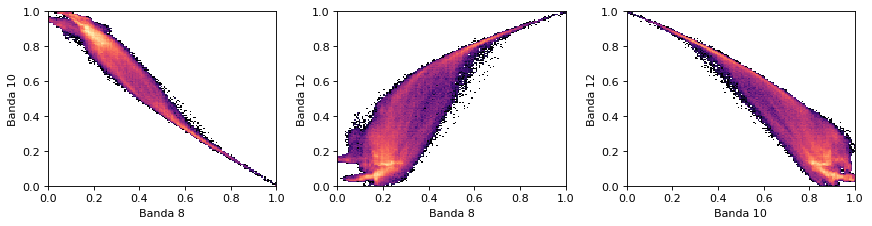

In [32]:
import matplotlib

# Creamos un objeto para normalizar las gráficas de forma logarítmica
lognorm = matplotlib.colors.LogNorm()

# Creamos la figura
plt.figure(figsize=(11, 8), dpi=80)

# Graficamos el dispersograma de las bandas 1 y 2
plt.subplot(3, 3, 1)

plt.hist2d(RGBrec_realzada[:, :, 0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           RGBrec_realzada[:, :, 1].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=150,                                                # Cantidad de bines para la gráfica
           #range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 8 y 9')
plt.xlabel('Banda 8')
plt.ylabel('Banda 10')

# Graficamos el dispersograma de las bandas 4 y 5
plt.subplot(3, 3, 2)

plt.hist2d(RGBrec_realzada[:, :, 0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           RGBrec_realzada[:, :, 2].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=150,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 10 y 11')
plt.xlabel('Banda 8')
plt.ylabel('Banda 12')

# Graficamos el dispersograma de las bandas 6 y 3
plt.subplot(3, 3, 3)

plt.hist2d(RGBrec_realzada[:, :, 1].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           RGBrec_realzada[:, :, 2].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=150,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 10')
plt.ylabel('Banda 12')


plt.tight_layout()
plt.show()

# Hacemos el dispersograma del analisis de componentes principales de la combinacion RGB anterior

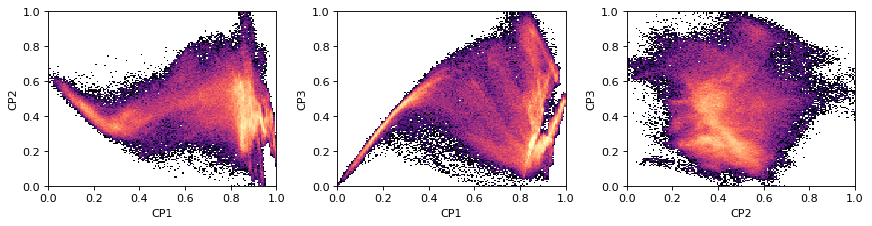

In [19]:
import matplotlib

# Creamos un objeto para normalizar las gráficas de forma logarítmica
lognorm = matplotlib.colors.LogNorm()

# Creamos la figura
plt.figure(figsize=(11, 8), dpi=80)

# Graficamos el dispersograma de las bandas 1 y 2
plt.subplot(3, 3, 1)

plt.hist2d(x_pca_3d_realzada[:, :, 0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           x_pca_3d_realzada[:, :, 1].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=150,                                                # Cantidad de bines para la gráfica
           #range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 8 y 9')
plt.xlabel('CP1')
plt.ylabel('CP2')

# Graficamos el dispersograma de las bandas 4 y 5
plt.subplot(3, 3, 2)

plt.hist2d(x_pca_3d_realzada[:, :, 0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           x_pca_3d_realzada[:, :, 2].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=150,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 10 y 11')
plt.xlabel('CP1')
plt.ylabel('CP3')

# Graficamos el dispersograma de las bandas 6 y 3
plt.subplot(3, 3, 3)

plt.hist2d(x_pca_3d_realzada[:, :, 1].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           x_pca_3d_realzada[:, :, 2].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=150,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('CP2')
plt.ylabel('CP3')


plt.tight_layout()
plt.show()

# Areas de lluvias intensas

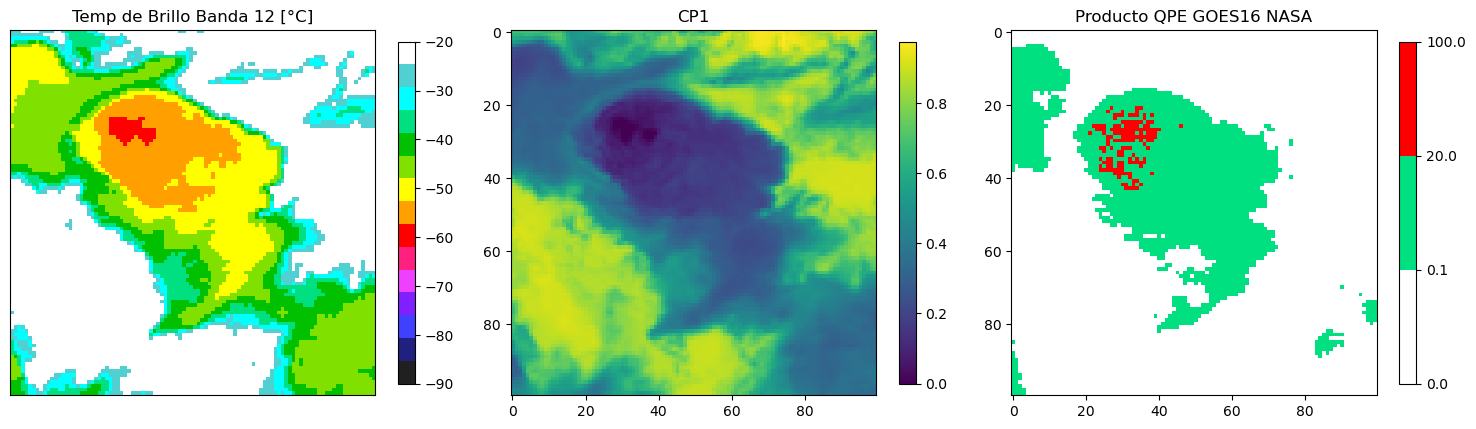

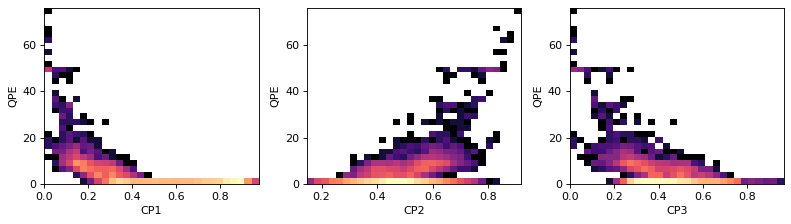

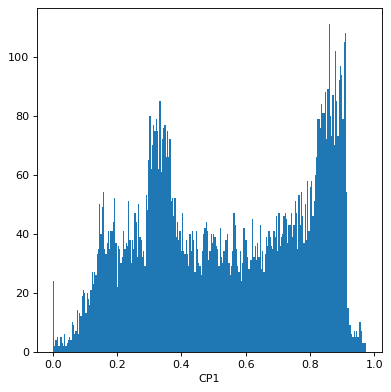

In [36]:
xmin = 175
xmax = 275
ymin = 0
ymax = 100

plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.imshow(imag_cal_list[bandaB][ymin:ymax, xmin:xmax], cmap=cmap_p.reversed(), vmin=-90.,vmax=-20.)
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 12 [°C]")

plt.subplot(132)
plt.imshow(x_pca_3d_realzada[ymin:ymax, xmin:xmax, 0])
plt.colorbar(shrink=.6)
plt.title('CP1')


plt.subplot(133)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax],
           cmap=cmap, norm=norm)
plt.title("Producto QPE GOES16 NASA")
plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
plt.tight_layout()

plt.show()


import matplotlib

# Creamos un objeto para normalizar las gráficas de forma logarítmica
lognorm = matplotlib.colors.LogNorm()

# Creamos la figura
plt.figure(figsize=(10, 8), dpi=80)

# Graficamos el dispersograma de las bandas 1 y 2
plt.subplot(3, 3, 1)

plt.hist2d(x_pca_3d_realzada[:, :, 0][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=30,                                                # Cantidad de bines para la gráfica
           #range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 8 y 9')
plt.xlabel('CP1')
plt.ylabel('QPE')

# Graficamos el dispersograma de las bandas 4 y 5
plt.subplot(3, 3, 2)

plt.hist2d(x_pca_3d_realzada[:, :, 1][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=30,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 10 y 11')
plt.xlabel('CP2')
plt.ylabel('QPE')

# Graficamos el dispersograma de las bandas 6 y 3
plt.subplot(3, 3, 3)

plt.hist2d(x_pca_3d_realzada[:, :, 2][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=30,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('CP3')
plt.ylabel('QPE')


plt.tight_layout()
plt.show()


plt.figure(figsize=(5, 5), dpi=80)
plt.subplot(1, 1, 1)
plt.hist(x_pca_3d_realzada[:, :, 0][ymin:ymax, xmin:xmax].flatten(), bins=250)
plt.xlabel('CP1')

plt.tight_layout()
plt.show()

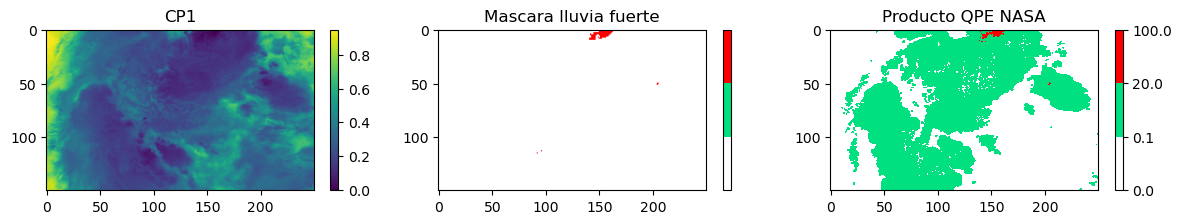

In [144]:
x_pca_realzada_copy = np.copy(x_pca_3d_realzada[ymin:ymax, xmin:xmax, :])

lluvia_intensa =  (x_pca_realzada_copy[:,:,0] < 0.05) 
#(x_pca_realzada_copy[:,:,1] > 0.7) * (x_pca_realzada_copy[:,:,2] > 0.25) * (x_pca_realzada_copy[:,:,2] < 0.35)

img_enmascarada = np.ones_like(x_pca_realzada_copy)
#img_filtrada = np.copy(x_pca_3d_realzada[:,:,:])

img_enmascarada[lluvia_intensa,1:3] = 0
img_enmascarada[lluvia_intensa,0]   = 1

##################################################################################################

plt.figure(figsize=(12, 3.5))

plt.subplot(131)
plt.imshow(x_pca_realzada_copy[:, :, 0])
plt.colorbar(shrink=.5)
plt.title("CP1")

plt.subplot(132)
plt.imshow(img_enmascarada, cmap=cmap)
plt.colorbar(shrink=.5, cmap=cmap, ticks=[])
plt.title('Mascara lluvia fuerte')

plt.subplot(133)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax],
           cmap=cmap, norm=norm)
plt.title("Producto QPE NASA")
plt.colorbar(shrink=.5, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)


plt.tight_layout()
plt.show()

# Areas de lluvias ligeras

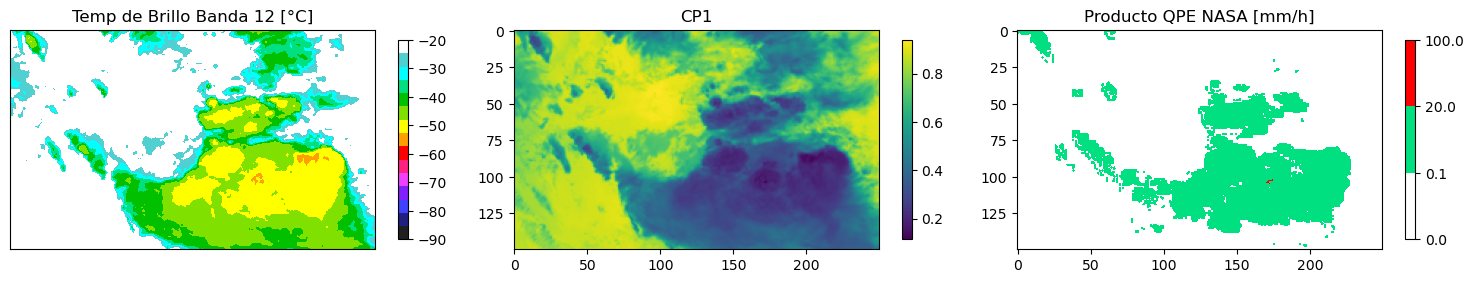

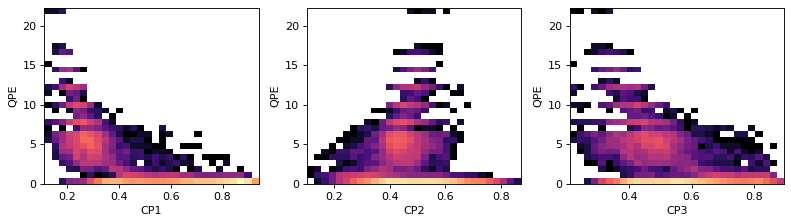

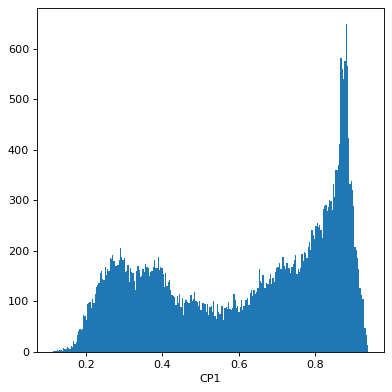

In [40]:
xmin = 100
xmax = 350
ymin = 100
ymax = 250

plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.imshow(imag_cal_list[bandaB][ymin:ymax, xmin:xmax], cmap=cmap_p.reversed(), vmin=-90.,vmax=-20.)
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.35)
plt.title("Temp de Brillo Banda 12 [°C]")

plt.subplot(132)
plt.imshow(x_pca_3d_realzada[ymin:ymax, xmin:xmax, 0])
plt.colorbar(shrink=.35)
plt.title('CP1')


plt.subplot(133)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax],
           cmap=cmap, norm=norm)
plt.title("Producto QPE NASA [mm/h]")
plt.colorbar(shrink=.35, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)


plt.tight_layout()

plt.show()


import matplotlib

# Creamos un objeto para normalizar las gráficas de forma logarítmica
lognorm = matplotlib.colors.LogNorm()

# Creamos la figura
plt.figure(figsize=(10, 8), dpi=80)

# Graficamos el dispersograma de las bandas 1 y 2
plt.subplot(3, 3, 1)

plt.hist2d(x_pca_3d_realzada[:, :, 0][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=30,                                                # Cantidad de bines para la gráfica
           #range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 8 y 9')
plt.xlabel('CP1')
plt.ylabel('QPE')

# Graficamos el dispersograma de las bandas 4 y 5
plt.subplot(3, 3, 2)

plt.hist2d(x_pca_3d_realzada[:, :, 1][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=30,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 10 y 11')
plt.xlabel('CP2')
plt.ylabel('QPE')

# Graficamos el dispersograma de las bandas 6 y 3
plt.subplot(3, 3, 3)

plt.hist2d(x_pca_3d_realzada[:, :, 2][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=30,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('CP3')
plt.ylabel('QPE')


plt.tight_layout()
plt.show()


plt.figure(figsize=(5, 5), dpi=80)
plt.subplot(1, 1, 1)
plt.hist(x_pca_3d_realzada[:, :, 0][ymin:ymax, xmin:xmax].flatten(), bins=250)
plt.xlabel('CP1')
plt.tight_layout()
plt.show()

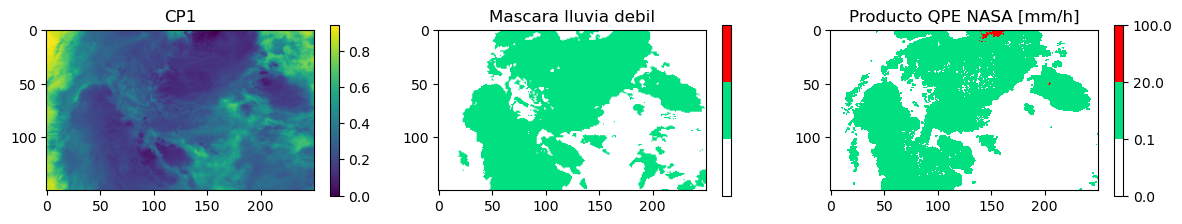

In [111]:
x_pca_realzada_copy = np.copy(x_pca_3d_realzada[ymin:ymax, xmin:xmax, :])

lluvia_ligera =  (x_pca_realzada_copy[:,:,0] >= 0.05) * (x_pca_realzada_copy[:,:,0] < 0.3)
#(x_pca_realzada_copy[:,:,1] > 0.4) * (x_pca_realzada_copy[:,:,2] < 0.2)

img_enmascarada = np.ones_like(x_pca_realzada_copy)
#img_filtrada = np.copy(x_pca_3d_realzada[:,:,:])

img_enmascarada[lluvia_ligera,0] = 0
img_enmascarada[lluvia_ligera,2] = 0.501960813999176
img_enmascarada[lluvia_ligera,1] = 0.8784313797950745

#lluvia_ligera_2dofiltro = (x_pca_realzada_copy[:,:,2] <= 0.25)
#img_enmascarada[lluvia_ligera_2dofiltro,0] = 0
#img_enmascarada[lluvia_ligera_2dofiltro,2] = 0.501960813999176
#img_enmascarada[lluvia_ligera_2dofiltro,1] = 0.8784313797950745
##################################################################################################

plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.imshow(x_pca_realzada_copy[:,:,0])
plt.title("CP1")
plt.colorbar(shrink=.3)

plt.subplot(132)
plt.imshow(img_enmascarada, cmap=cmap)
plt.title('Mascara lluvia debil')
plt.colorbar(shrink=.3, cmap=cmap, ticks=[])

plt.subplot(133)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax],
           cmap=cmap, norm=norm)
plt.title("Producto QPE NASA [mm/h]")
plt.colorbar(shrink=.3, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)


plt.tight_layout()
plt.show()

# Combinacion de areas de lluvias fuertes y ligeras

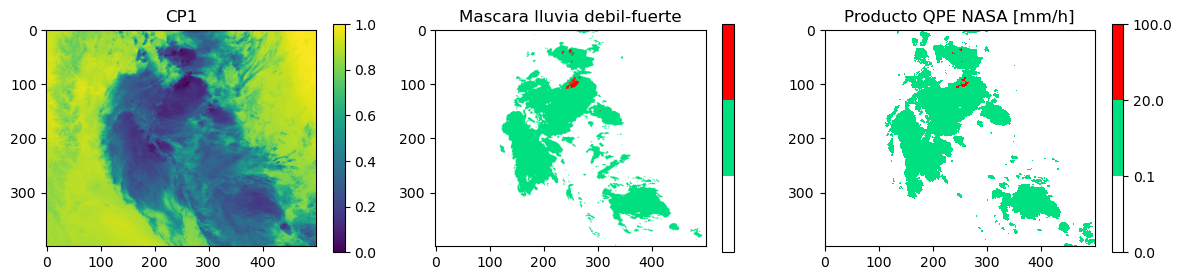

In [110]:
#lluvia_ligera =  (x_pca_3d_realzada[:,:,1] < 0.7) *\
#(x_pca_3d_realzada[:,:,1] > 0.4) * (x_pca_3d_realzada[:,:,2] < 0.2)

#lluvia_intensa =  (x_pca_3d_realzada[:,:,0] < 0.025) * (x_pca_3d_realzada[:,:,1] > 0.9) *\
#(x_pca_3d_realzada[:,:,2] < 0.025)

lluvia_ligera =  (x_pca_3d_realzada[:,:,0] >= 0.05) * (x_pca_3d_realzada[:,:,0] < 0.3)
lluvia_intensa =  (x_pca_3d_realzada[:,:,0] < 0.05) 

img_enmascarada = np.ones_like(x_pca_3d_realzada)
#img_filtrada = np.copy(x_pca_3d_realzada[:,:,:])

img_enmascarada[lluvia_intensa,1:3] = 0
img_enmascarada[lluvia_intensa,0]   = 1

img_enmascarada[lluvia_ligera,0] = 0
img_enmascarada[lluvia_ligera,2] = 0.501960813999176
img_enmascarada[lluvia_ligera,1] = 0.8784313797950745

##################################################################################################

plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.imshow(x_pca_3d_realzada[:,:,0])
plt.colorbar(shrink=.4)
plt.title("CP1")

plt.subplot(132)
plt.imshow(img_enmascarada, cmap=cmap)
plt.colorbar(shrink=.4, cmap=cmap, ticks=[])
plt.title('Mascara lluvia debil-fuerte')

plt.subplot(133)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
           cmap=cmap, norm=norm)
plt.title("Producto QPE NASA [mm/h]")
plt.colorbar(shrink=.4, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)

plt.tight_layout()

plt.show()

In [ ]:
for h in range(len(CH08_list)):
    
    list_imgs = [CH08_list[h],CH10_list[h],CH12_list[h]]
    
    qpe_obj = Dataset(QPE_list[h], 'r')
    
    print('Procesando ', CH08_list[h])
    print('Procesando ', CH10_list[h])
    print('Procesando ', CH12_list[h])
    print('Procesando ', QPE_list[h])
                      
    imagenobj_list = []

#     print('Importando imagenes...')
    for i in range(len(list_imgs)): imagenobj_list.append(Dataset(list_imgs[i], 'r'))
#     print('Imagenes importadas en la lista imagenobj_list.')

    metadato_list = [imagenobj_list[i].variables for i in range(len(list_imgs))]

    # Recorte en la Argentina basados en las bandas con 2 km de resolución espacial
    # Si la banda es de 1 km y 0.5 km de resolución entonces se debe multiplicar estos valores por 2 y 4
    # respectivamente, de forma tal de obtener el mismo recorte

    # RECORTE DE SUDAMERICA
    #sup_row = 4000
    #inf_row = 5000
    #sup_col = 2500
    #inf_col = 3600

    # CENTRO DE LA ARGENTINA
    sup_row = 4200
    inf_row = 4600
    sup_col = 2900
    inf_col = 3400

    #print('Tamaño del recorte: Alto=',inf_row-sup_row,' Ancho=',inf_col-sup_col)

    imagen_list = []
    imag_cal_list = []

    for metadato in metadato_list:

        try:
            # altura de la orbita del satelite en metros (35786023.0)
            altura=metadato['goes_imager_projection'].perspective_point_height
            # 6378137.0 semieje mayor en metros
            semieje_may=metadato['goes_imager_projection'].semi_major_axis
            # 6356752.31414 semieje menor en metros
            semieje_men=metadato['goes_imager_projection'].semi_minor_axis
            # -75 longitud central
            lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin

            #img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
            img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
            pol=semieje_may*altura/(semieje_may+altura) # 5413321.583523803
            ecu=semieje_men*altura/(semieje_may+altura) # 5395171.741097588

            icanal = int(metadato['band_id'][:])
#             print ('Procesando Canal %d' %icanal)
            #print('pol',pol,' ecu',ecu)
            ####################################################################################################
            imagen = metadato['Rad'][:].data
            imagen_list.append(imagen)
#             print('Tamaño original de la imagen:',imagen.shape)
#             print('Recortando imagen')
            # Bandas de 1 km de resolución espacial
            if (icanal == 1) or (icanal == 3) or (icanal == 5):
#                 print('entra al if 1,3,5')
                imagen = imagen[sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2]
            # Bandas de 0.5 km de resolución espacial
            elif icanal == 2:
#                 print('entra al elif 2')
                imagen = imagen[sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4]
            # Bandas de 2 km de resolución espacial
            else:
#                 print('entra al else')
                imagen = imagen[sup_row:inf_row,sup_col:inf_col]
            ####################################################################################################
            if icanal >7:
#                 print ('Calibrando la imagen (if)')
                #Parámetros de calibracion
                fk1 = metadato['planck_fk1'][0] # DN -> K  (=13432.1)
                fk2 = metadato['planck_fk2'][0] # (=1497.61)
                bc1 = metadato['planck_bc1'][0] # (=0.09102)
                bc2 = metadato['planck_bc2'][0] # (=0.99971)

                imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2-273.15 # K -> C
                imag_cal_list.append(imag_cal)
                # imag_cal es un array de (5424, 5424)
                Unit = "Temperatura de Brillo [°C]"
            else:
#                 print ('Calibrando la imagen (else)')
                pendiente= metadato['Rad'].scale_factor
                ordenada= metadato['Rad'].add_offset
                imag_cal =imagen*pendiente+ordenada
                imag_cal_list.append(imag_cal)
                Unit = "Radiancia ["+metadato['Rad'].units+"]"  
        except:
            print('Se ingresó al bloque except!')
            continue

        print('\n') 



    RGBrec = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))

    #bandaR = 8-8
    #bandaG = 10-8
    #bandaB = 12-8

    RGBrec[:, :, 0] = 1-imag_cal_list[0]
    RGBrec[:, :, 1] = imag_cal_list[1]
    RGBrec[:, :, 2] = 1-imag_cal_list[2]

    # bandaR = 11-8
    # bandaG = 12-8
    # bandaB = 14-8

    # RGBrec[:, :, 0] = 1-imag_cal_list[bandaR]
    # RGBrec[:, :, 1] = imag_cal_list[bandaG]
    # RGBrec[:, :, 2] = 1-imag_cal_list[bandaB]

    # Armos X_pca para la nueva imagen
    X_pca = pca_modificada(RGBrec, eigen_vecs)

    x_pca_3d = np.reshape(X_pca, [inf_row-sup_row, inf_col-sup_col, 3])

    # Aplique un realce a x_pca_3d
    x_pca_3d_realzada = np.zeros_like(x_pca_3d)
    for l in range(3):
        x_pca_3d_realzada[:, :, l] = realce(x_pca_3d[:, :, l], p=0.01)

    # Aplique un realce a x_pca_3d
    RGBrec_realzada = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))
    for m in range(3):
        RGBrec_realzada[:,:,m] = realce(RGBrec[:,:,m], p=0.01)
#########################################################################################################
#     plt.figure(figsize=(15, 6))

#     plt.subplot(131)
#     plt.imshow(imag_cal_list[2], cmap=cmap_p.reversed(), vmin=-90.,vmax=-20.)
#     plt.title("Imagen Original RGB Bandas 8,10 y 12")
#     plt.colorbar(shrink=.35)

#     plt.subplot(132)
#     plt.imshow(x_pca_3d_realzada[:,:,0])
#     plt.title('Componentes principal 1')


#     plt.subplot(133)
#     plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
#                cmap=cmap, norm=norm)
#     plt.title("Producto QPE GOES16 NASA")
#     #plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)

#     plt.tight_layout()

#     plt.show()

#########################################################################################################

    lluvia_ligera  =  (x_pca_3d_realzada[:,:,0] >= 0.05) * (x_pca_3d_realzada[:,:,0] < 0.3)
    lluvia_intensa =  (x_pca_3d_realzada[:,:,0] < 0.05) 

    img_enmascarada = np.ones_like(x_pca_3d_realzada)
    #img_filtrada = np.copy(x_pca_3d_realzada[:,:,:])

    img_enmascarada[lluvia_intensa,1:3] = 0
    img_enmascarada[lluvia_intensa,0]   = 1

    img_enmascarada[lluvia_ligera,0] = 0
    img_enmascarada[lluvia_ligera,2] = 0.501960813999176
    img_enmascarada[lluvia_ligera,1] = 0.8784313797950745

    ##################################################################################################

    plt.figure(figsize=(13, 3.5))

    plt.subplot(131)
    img = plt.imshow(img_enmascarada, cmap)
    cbar = plt.colorbar(img, ticks=[0.15, 0.5, 0.9], shrink=.8, cmap=cmap)
    cbar.ax.set_yticklabels(['Sin lluvia','Lluvia débil', 'Lluvia fuerte'],
                            fontdict={'rotation':90, 'va':'center'})  # vertically oriented colorbar
    plt.title('Mascara lluvia debil-fuerte')
    plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
#     plt.colorbar(shrink=.5, cmap=cmap)

    plt.subplot(132)
    plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
               cmap=cmap, norm=norm)
    plt.title("Producto QPE GOES16 NASA [mm/h]")
    plt.colorbar(shrink=.8, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
    plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
    
    plt.text(220, 450, CH12_list[h].split('G16_s')[-1][7:11]+' Z', fontdict={'fontsize':18})
    
    plt.subplot(133)
#     plt.imshow(x_pca_3d_realzada[:,:,0])
#     plt.title("Componenente Principal 1")
#     plt.colorbar(shrink=.5)
    plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
               cmap=cmap_p, vmin=0, vmax=100)
    plt.title("Producto QPE GOES16 NASA [mm/h]")
    plt.colorbar(shrink=.8, cmap=cmap_p)
    plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
    

    plt.tight_layout()
    plt.savefig('/home/msuarez/GOES_16_TF/Mascara/Figura-'+str(h)+'.png', dpi=150)
    plt.show()